In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, AutoTokenizer
import seaborn as sn
import matplotlib.pyplot as plt
from datasets import Dataset
from datasets import load_dataset
from dateutil import parser



In [27]:
import os
import sys
from dotenv import load_dotenv

#For Desktop 
#s.environ['PYSPARK_PYTHON'] = sys.executable
#os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from huggingface_hub import login

#For Desktop
#login(token=os.getenv("HF_MASTER_KEY"))

#For Macbook
load_dotenv()
login(token=os.getenv("MACBOOK_HF_KEY"))

# Clear conflicting environment variables
#if 'PYTHONPATH' in os.environ:
    #del os.environ['PYTHONPATH']



In [3]:
from pyspark.sql import SparkSession
from datasets import load_dataset
import pandas as pd

# Test run with Reuters and Ashraq financial news dataset
reuters_spark = SparkSession.builder.appName("ReutersNews").getOrCreate()
finnews_spark = SparkSession.builder.appName('FinNews').getOrCreate()

# Dictionary mapping spark sessions to dataset names
spark_dataset_mapping = {
    reuters_spark: "danidanou/Reuters_Financial_News",
    finnews_spark: "ashraq/financial-news-articles"
}

def ds_to_spark(spark_session, dataset_name, dataset_size=10000):
    """
    Convert a HuggingFace dataset to a Spark DataFrame
    
    Args:
        spark_session: Active Spark session
        dataset_name: HuggingFace dataset name/path
        dataset_size: Number of rows to load (default: 10000)
    
    Returns:
        Spark DataFrame or None if failed
    """
    from pyspark.sql.types import StructType, StructField, StringType
    
    print(f"Loading dataset: {dataset_name}")
    
    try:
        # Load HuggingFace dataset with size limit
        hf_df = load_dataset(dataset_name, split=f'train[:{dataset_size}]')
        
        # Convert to pandas
        pd_df = hf_df.to_pandas()
        
        print(f"DF shape: {pd_df.shape}")
        
        # Check and clean columns
        for col in pd_df.columns:
            if pd_df[col].dtype == 'object':
                # Get a sample of non-null values
                non_null_values = pd_df[col].dropna()
                
                if len(non_null_values) > 0:
                    # Check the first few values to determine type
                    sample_value = non_null_values.iloc[0]
                    
                    if isinstance(sample_value, (list, dict)):
                        # Convert complex types to string
                        pd_df[col] = pd_df[col].apply(lambda x: str(x) if x is not None else "")
                        print(f"Converted col '{col}' to string")
        
        # Fill null values
        pd_df = pd_df.fillna("")
        
        try:
            # Convert pandas DataFrame to list of Row objects for compatibility
            records = pd_df.to_dict('records')
            spark_df = spark_session.createDataFrame(records)
            print(f"Successfully created Spark DataFrame for {dataset_name}")
            print("Schema:")
            spark_df.printSchema()
            return spark_df
            
        except Exception as e:
            print(f"Error creating DataFrame for {dataset_name}: {e}")
            
            # Alternative approach: Define explicit schema and use records
            print("Trying with explicit string schema and records conversion...")
            
            try:
                # Create schema with all string types
                string_schema = StructType([
                    StructField(col, StringType(), True) for col in pd_df.columns
                ])
                
                # Convert all columns to string
                pd_df_str = pd_df.astype(str)
                
                # Convert to records format
                records = pd_df_str.to_dict('records')
                
                # Create Spark DataFrame with explicit schema
                spark_df = spark_session.createDataFrame(records, schema=string_schema)
                print(f"Successfully created Spark DataFrame with string schema for {dataset_name}")
                print("Schema:")
                spark_df.printSchema()
                return spark_df
                
            except Exception as e2:
                print(f"Failed even with string schema and records: {e2}")
                
                # Last resort: Manual row creation
                print("Trying manual row creation...")
                try:
                    from pyspark.sql import Row
                    
                    # Create Row objects manually
                    Row = Row(*pd_df.columns)
                    rows = [Row(*[str(val) for val in row]) for row in pd_df.values]
                    
                    spark_df = spark_session.createDataFrame(rows)
                    print(f"Successfully created Spark DataFrame with manual row creation for {dataset_name}")
                    print("Schema:")
                    spark_df.printSchema()
                    return spark_df
                    
                except Exception as e3:
                    print(f"All methods failed for {dataset_name}: {e3}")
                    return None
    
    except Exception as e:
        print(f"Error loading dataset {dataset_name}: {e}")
        return None



----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61201)
Traceback (most recent call last):
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "C:\spark\spark-3.5.6-bin-hadoop3\python\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "C:\spark\spark-3.5.6-bin-hadoop3\python\pyspark\accumulators.py", line 267, in poll
    if self

In [171]:
from datasets import load_dataset
reuters_df = load_dataset("danidanou/Reuters_Financial_News")['train'].to_pandas()
finnews_df = load_dataset("ashraq/financial-news-articles")['train'].to_pandas()

reuters_df = reuters_df.rename(columns={
    'Article': 'text',
    'Link': 'url',
    'Headline': 'title'
    })

reuters_df = reuters_df.drop(columns=['Journalists', '__index_level_0__', 'Summary'])

#Merging the df
merged_df = pd.concat([reuters_df, finnews_df])

#Shuffling the rows
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

#Removing duplicates based on url
merged_df = merged_df.drop_duplicates(subset=['url'], keep='first')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411547 entries, 0 to 411600
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   411547 non-null  object
 1   Date    105359 non-null  object
 2   url     411547 non-null  object
 3   text    411547 non-null  object
dtypes: object(4)
memory usage: 15.7+ MB


In [177]:
#DATA CLEANING 


merged_df['text_length'] = merged_df['text'].apply(lambda text: len(text))

merged_df['news_medium'] = merged_df['url'].str.extract(r'https?://([^/]+)')[0].str.replace('www.', '', regex=False).str[:-4]

#Standardizing dates and getting more date information from url

#Turning string dates to YYYY-MM-DD HH:MM:SS Format
merged_df['Date'] = merged_df['Date'].apply(lambda date: parser.parse(date) if pd.notna(date) else np.NaN)


#Getting dates from URL


url_dates = merged_df['url'].str.extract(r'/(\d{4})[/\-](\d{2})[/\-](\d{2})/').dropna().T.apply('-'.join)

merged_df['Date'] = merged_df['Date'].fillna(url_dates)


merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

merged_df['Date'] = merged_df['Date'].dt.strftime("%Y-%m-%d")


#News article types
merged_df['news_type'] = merged_df['url'].str.extract(r'/([a-zA-Z]+)/')[0]

merged_df


,title,Date,url,text,text_length,news_medium,news_type
0,Europe hails but won't copy Obama bank fee plan,2010-01-15,http://www.reuters.com/article/2010/01/15/us-e...,"""We have to see now in Europe ... whether we ...",3259,reuters,article
1,Invitation - Presentation of Sobi's Q1 2018 Re...,2018-04-19,http://www.cnbc.com/2018/04/19/pr-newswire-inv...,"STOCKHOLM, April 19, 2018 /PRNewswire/ -- On 2...",2326,cnbc,NaN
2,Gold 'loves any turbulence' as metal rises fol...,2018-03-13,https://www.cnbc.com/2018/03/13/gold-loves-any...,Gold was bid higher after Secretary of State R...,1640,cnbc,NaN
3,De Villiers ton hands South Africa commanding ...,NaN,https://uk.reuters.com/article/uk-cricket-test...,"March 11, 2018 / 10:30 AM / in 27 minutes Khaw...",2566,uk.reuters,article
4,"UPDATE 8-Oil eases, but avoids stocks-style vo...",2018-02-06,https://www.cnbc.com/2018/02/06/reuters-americ...,"* Wall St slumps, volatility index nears three...",2651,cnbc,NaN
...,...,...,...,...,...,...,...
411596,Weinstein 'believes he will be forgiven' by Ho...,2018-04-29,https://www.cnbc.com/2018/04/29/reuters-americ...,"LONDON, April 29 (Reuters) - Movie producer Ha...",1742,cnbc,NaN
411597,Venezuela's opposition coalition likely to boy...,NaN,https://www.reuters.com/article/us-venezuela-p...,CARACAS (Reuters) - Leaders of Venezuela’s opp...,2812,reuters,article
411598,"Anadarko, Tronox trial halted for settlement t...",2012-07-12,http://www.reuters.com/article/2012/07/12/us-a...,The two companies are locked in a $25 billion...,775,reuters,article
411599,"Data breach hits JPMorgan, Kroger customers",2011-04-01,http://www.reuters.com/article/2011/04/02/us-e...,The data breach included some email addresses...,1808,reuters,article


In [ ]:
#reuters_df = ds_to_spark(reuters_spark, "danidanou/Reuters_Financial_News", 30000)
#finnews_df = ds_to_spark(finnews_spark, "ashraq/financial-news-articles", 30000)

# Check if successful
#if reuters_df:
    #print("Reuters dataset loaded successfully")
    #reuters_df.show(5)

#if finnews_df:
    #print("Financial News dataset loaded successfully") 
    #finnews_df.show(5)

Loading dataset: danidanou/Reuters_Financial_News
DF shape: (30000, 7)
Error creating DataFrame for danidanou/Reuters_Financial_News: [CANNOT_INFER_TYPE_FOR_FIELD] Unable to infer the type of the field `Journalists`.
Trying with explicit string schema and records conversion...
Successfully created Spark DataFrame with string schema for danidanou/Reuters_Financial_News
Schema:
root
 |-- Headline: string (nullable = true)
 |-- Journalists: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Link: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- __index_level_0__: string (nullable = true)

Loading dataset: ashraq/financial-news-articles
DF shape: (30000, 3)
Successfully created Spark DataFrame for ashraq/financial-news-articles
Schema:
root
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)

Reuters dataset loaded successfully
+--------------------+------------

/Users/cristianzuniga/Library/Python/3.10/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 2400x600 with 0 Axes>

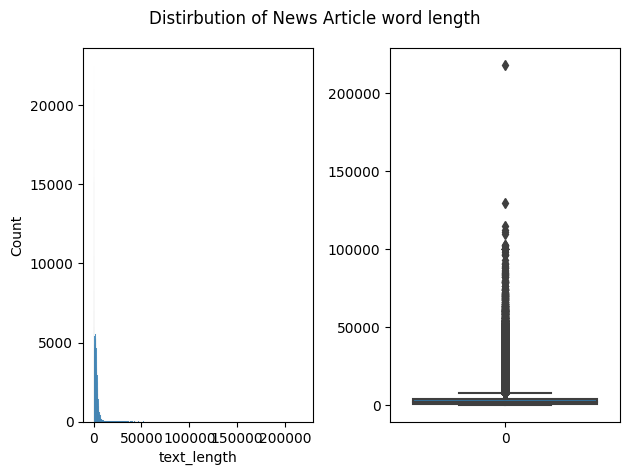

In [4]:

plt.figure(figsize=(24,6))

fig, axs = plt.subplots(ncols=2)



fig.suptitle('Distirbution of News Article word length')

sn.histplot(data=merged_df['text_length'], ax=axs[0])

sn.boxplot(data=merged_df['text_length'], ax=axs[1])
plt.tight_layout()
plt.show()

In [29]:
merged_df["text_length"].describe()

count    411601.000000
mean       2606.701626
std        4176.968322
min           0.000000
25%         534.000000
50%        1786.000000
75%        3293.000000
max      218108.000000
Name: text_length, dtype: float64

In [16]:
#We'll do 3 methods the first will be to take the first 512 words of an article (if it has it), combine into a column for a dataframe
#The second method will be to take the middle 512 words (if available) of an article and combine into a column
#The third will be to take the first 2000 words of an article, combine into a column 

from pyspark.sql.functions import substring, col, expr
from pyspark.sql.types import IntegerType



#Method one
first_512_df = merged_df[merged_df['text_length'] >= 512]

#Method two

#Making a function to define middle of column
middle_512_df = merged_df
middle_512_df['text'] = merged_df['text'].apply(
    lambda text: text[int((len(text) - 512) / 2):int(len(text) - (len(text) - 512) / 2)]
)

#Third_method
first_4096_df = merged_df[merged_df["text_length"] >= 4096]





In [21]:
tokenized_datasets

{}

In [23]:
datasets_hf['first_512']

Dataset({
    features: ['title', 'url', 'text', 'text_length', '__index_level_0__'],
    num_rows: 314651
})

In [24]:
#The third method will feed into a longform tranfsformer for pretraining
#The second method and first method will feed into a DistilBERT for pretraining
#We'll use a one lstm that will train on the first 512 words (benchmark, to be added later)


#Bert tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
lf_tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

datasets_pd = {
    'first_512': first_512_df,
    'middle_512': middle_512_df, 
    'first_4096': first_4096_df
}

    
# Tokenize
datasets_hf = {
    name: Dataset.from_pandas(df) 
    for name, df in datasets_pd.items()
}


configs = [
    {'name': 'first_512', 'tokenizer': bert_tokenizer, 'max_length': 512},
    {'name': 'middle_512', 'tokenizer': bert_tokenizer, 'max_length': 512},
    {'name': 'first_4096', 'tokenizer': lf_tokenizer, 'max_length': 4096}
]


tokenized_datasets = {}


for config in configs:
    tokenized_datasets[config['name']] = datasets_hf[config['name']].map(
        lambda examples: config['tokenizer'](
            examples['text'],  # adjust column name as needed
            truncation=True,
            padding='max_length',
            max_length=config['max_length'],
            return_tensors='pt'
        ),
        batched=True
    )

Map:   0%|          | 0/314651 [00:00<?, ? examples/s]

Map:   0%|          | 0/411601 [00:00<?, ? examples/s]

Map:   0%|          | 0/67030 [00:00<?, ? examples/s]

In [25]:
for dataset in tokenized_datasets.keys():
    tokenized_datasets[dataset].push_to_hub(f"Czunzun/Financial_news_{dataset}")

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/79 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/79 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/79 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/79 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/369 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/138 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/138 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/138 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/370 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/369 [00:00<?, ?B/s]

In [15]:
169826664 > 35833704

True